In [1]:
#!/usr/bin/env python3
# --------------------------------------------------------------
# Author: Mahendra Data - mahendra.data@dbms.cs.kumamoto-u.ac.jp
# License: BSD 3 clause
# --------------------------------------------------------------

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!nvidia-smi

Tue Aug 11 01:05:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import logging

import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)


In [5]:
PROCESSED_DIR_PATH = "/content/drive/My Drive/CICIDS2017/ProcessedDataset"
MODEL_DIR_PATH = "/content/drive/My Drive/CICIDS2017/Model"

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)

    # Split features and labels
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # Scale the features between 0 ~ 1
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))


In [7]:
def create_cnn_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(9, 9, 1))
    x = keras.layers.Conv2D(120, 2, activation='relu', padding="same")(inputs)
    x = keras.layers.Conv2D(60, 3, activation='relu', padding="same")(x)
    x = keras.layers.Conv2D(30, 4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

In [8]:
# Create model
model = create_cnn_model()
logging.info(model.summary())

01:06:02 INFO None


Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9, 9, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 120)         600       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 60)          64860     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 30)          28830     
_________________________________________________________________
flatten (Flatten)            (None, 2430)              0         
_________________________________________________________________
dense (Dense)                (None, 15)                36465     
Total params: 130,755
Trainable params: 130,755
Non-trainable params: 0
_________________________________________________________

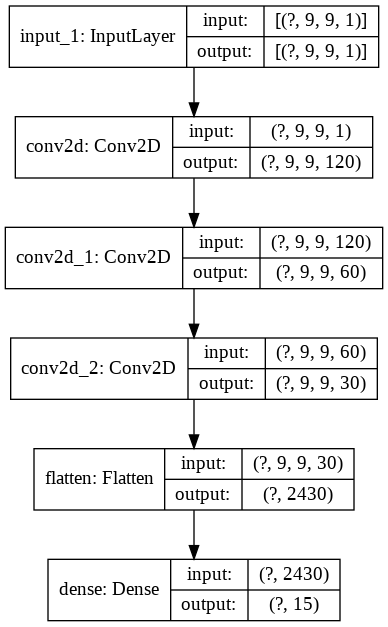

In [9]:
plot_model(model, show_shapes=True)

In [10]:
# Checkpoint
cp_path = os.path.join(MODEL_DIR_PATH, "5_2_cnn_weights-improvement-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(cp_path, monitor='val_sparse_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

01:06:22 INFO Class distribution
0     1818477
4      184858
10     127144
2      102421
3        8234
7        6350
11       4718
6        4637
5        4399
1        1573
12       1206
14        522
9          29
13         17
8           9
Name: Label, dtype: int64


In [11]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [12]:
# Training
logging.info("*** TRAINING START ***")
history = model.fit(X, Y, validation_split=0.1, epochs=125, batch_size=1024, verbose=True)

01:06:28 INFO *** TRAINING START ***


Epoch 1/125
1991/1991 [==============================] - 43s 22ms/step - loss: 0.1194 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.0601 - val_sparse_categorical_accuracy: 0.9749
Epoch 2/125
1991/1991 [==============================] - 43s 21ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0351 - val_sparse_categorical_accuracy: 0.9857
Epoch 3/125
1991/1991 [==============================] - 42s 21ms/step - loss: 0.0300 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.0268 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/125
1991/1991 [==============================] - 42s 21ms/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9933 - val_loss: 0.0156 - val_sparse_categorical_accuracy: 0.9970
Epoch 5/125
1991/1991 [==============================] - 42s 21ms/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0122 - val_sparse_categorical_accuracy: 0.9976
Epoch 6/125
1991/1991 [==============================] - 42s 21ms/step - lo

In [13]:
logging.info("*** TRAINING FINISH ***")
del X, Y

02:33:52 INFO *** TRAINING FINISH ***


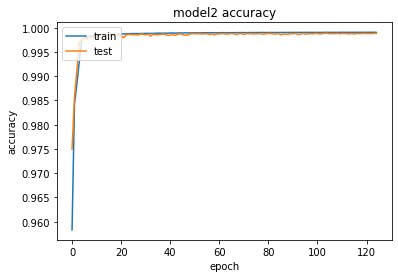

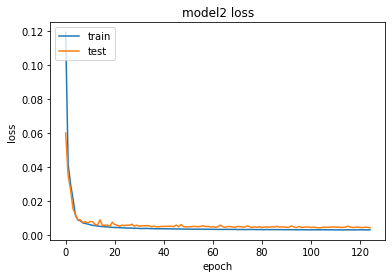

In [14]:
# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "06_cnn.h5"))

plot_history(history)

In [16]:
# Evaluation
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'test_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

03:10:12 INFO Class distribution
0     454620
4      46215
10     31786
2      25606
3       2059
7       1588
11      1179
6       1159
5       1100
1        393
12       301
14       130
9          7
13         4
8          2
Name: Label, dtype: int64


In [17]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [18]:
evaluation(model, X, Y)
del X, Y

03:10:48 INFO Evaluation:
Loss: 0.02802629955112934
Accuracy : 0.9968135356903076

03:10:52 INFO 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.99      0.42      0.59       393
           2       1.00      0.99      1.00     25606
           3       0.99      1.00      1.00      2059
           4       1.00      1.00      1.00     46215
           5       0.99      0.94      0.96      1100
           6       1.00      0.88      0.93      1159
           7       0.96      1.00      0.98      1588
           8       1.00      0.50      0.67         2
           9       1.00      0.29      0.44         7
          10       0.99      0.99      0.99     31786
          11       0.99      0.51      0.67      1179
          12       0.71      0.99      0.83       301
          13       0.50      0.25      0.33         4
          14       0.91      0.08      0.14       130

    accuracy                        

In [19]:
logging.info("*** END ***")

03:10:52 INFO *** END ***
